In [123]:
import pandas as pd
import pmdarima as pm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

#Configs
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
set_config(transform_output='pandas')

In [124]:
#File names

path = './data/'
transactions = 'transactions.csv'
train = 'train.csv'
test = 'test.csv'
stores = 'stores.csv'
oil = 'oil.csv'
holidays_events = 'holidays_events.csv'

In [125]:
#Reading in csv files
df_train = pd.read_csv(path + train)
df_test = pd.read_csv(path + test)
df_stores = pd.read_csv(path + stores)
df_transactions = pd.read_csv(path + transactions)
df_oil = pd.read_csv(path + oil)
df_holidays = pd.read_csv(path + holidays_events)

In [126]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [127]:
#Datetime conversion
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [128]:
df_train.sort_values(by=['date'], inplace=True)
df_test.sort_values(by=['date'], inplace=True)
df_oil.sort_values(by=['date'], inplace=True)
df_holidays.sort_values(by=['date'], inplace=True)
df_transactions.sort_values(by=['date'], inplace=True)

In [129]:
#Missing data
df_oil.isnull().sum()

#Impute first value with second value
df_oil['dcoilwtico'][0] = df_oil['dcoilwtico'][1]

#Linear interpolation of missing values in oil timeseries
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

#Exploding the df_oil index to one continuous time series
df_oil = df_oil.set_index('date').resample('D').ffill().reset_index()
df_oil

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
...,...,...
1699,2017-08-27,47.65
1700,2017-08-28,46.40
1701,2017-08-29,46.46
1702,2017-08-30,45.96


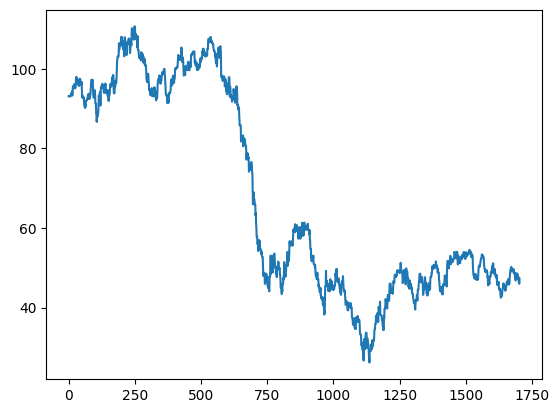

In [130]:
#Convert df_oil to price difference from previous day in percent
df_oil['dcoilwtico'].plot()
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].pct_change()
df_oil['price_shock'] = df_oil['dcoilwtico'].apply(lambda x: 1 if x > 0.10 or x < -0.10 else 0)

In [131]:
#Adding transactions, holidays, oil prices and store information to train and test, and setting date as index
df_train = df_train.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_train = df_train.merge(df_oil, on=['date'], how='left')
df_train = df_train.merge(df_stores, on=['store_nbr'], how='left')

df_test = df_test.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_test = df_test.merge(df_oil, on=['date'], how='left')
df_test = df_test.merge(df_stores, on=['store_nbr'], how='left')

#Adding payday flags on 1st and 15th of each month
df_train['payday'] = df_train['date'].dt.day.isin([1, 15]).astype(int)
df_test['payday'] = df_test['date'].dt.day.isin([1, 15]).astype(int)

#Drop type column
df_train.drop('type', axis=1, inplace=True)
df_test.drop('type', axis=1, inplace=True)

<Axes: title={'center': 'Sales by date'}, xlabel='date'>

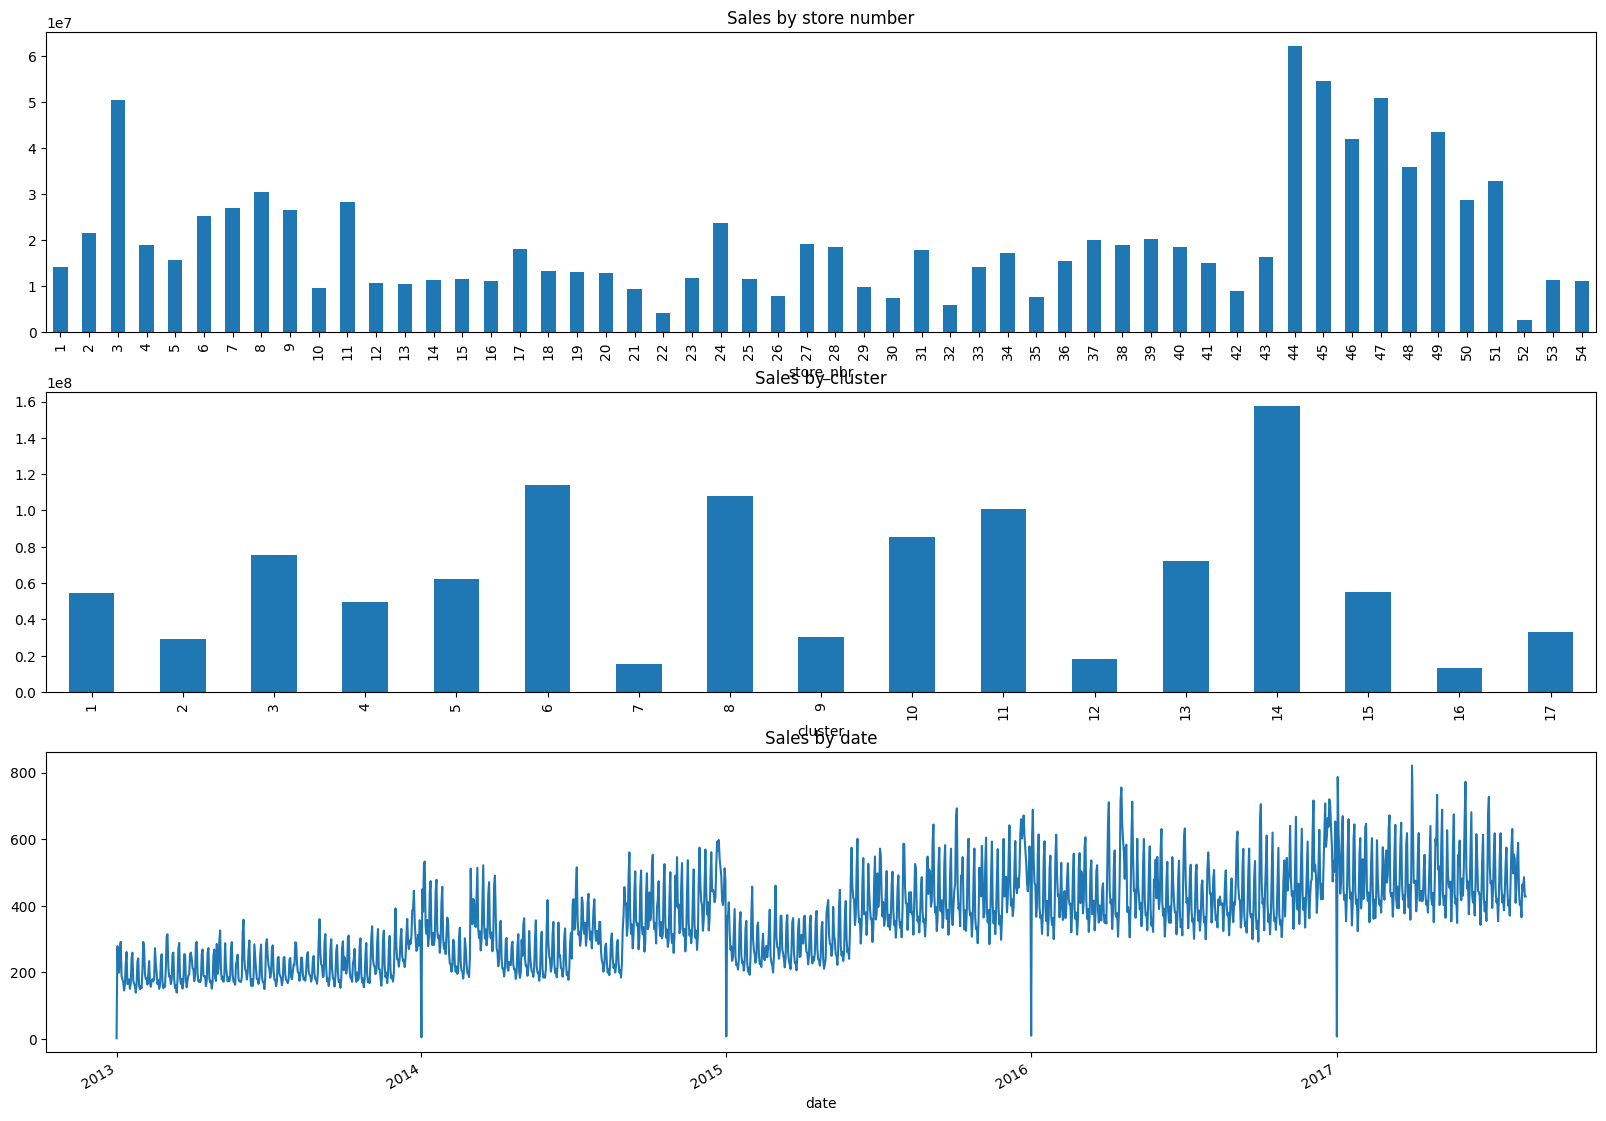

In [132]:
#Comparing sales across store_nbd
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,15))
df_train.groupby('store_nbr')['sales'].sum().plot(kind='bar', ax=ax1, title='Sales by store number')
df_train.groupby('cluster')['sales'].sum().plot(kind='bar', ax=ax2, title='Sales by cluster')
df_train.groupby('date')['sales'].mean().plot(ax=ax3, title='Sales by date')

In [133]:
def process_holidays(df, df_holidays):
    '''
    Function to process holidays events
    '''

    #Dropping duplicate holidays by locale_name and date
    df_holidays = df_holidays.drop_duplicates(subset=['locale_name', 'date'])

    #Getting local, regional and national holiday dfs
    df_holidays_local = df_holidays[df_holidays['locale'] == 'Local']
    df_holidays_regional = df_holidays[df_holidays['locale'] == 'Regional']
    df_holidays_national = df_holidays[df_holidays['locale'] == 'National']

    #Merging holiday dfs with train dataset
    df = df.merge(df_holidays_local, left_on=['date', 'city'], right_on= ['date', 'locale_name'], how='left')
    df = df.merge(df_holidays_regional, left_on=['date', 'state'], right_on= ['date', 'locale_name'], how='left')
    df = df.merge(df_holidays_national, on=['date'], how='left')

    #Adding new year flag
    df['new_years'] = df['date'].apply(lambda x: 1 if x.month == 1 and x.day == 1 else 0)

    #Dropping unnecessary columns created in joining holiday dfs
    df.drop(columns=['locale_x', 'locale_name_x', 'description_x', 'locale_y', 'locale_name_y', 'description_y', 'locale', 'locale_name', 'transferred'], inplace=True)

    #Generating one event_type column which is the type of holiday if there is one, and has 'normal' if not
    df['event_type'] = df['type_x'].fillna(df['type_y']).fillna(df['type']).fillna('normal')
    
    #Add earthquake impact
    df['earthquake'] = df['date'].apply(lambda x: 1 if x.month == 4 and x.day == 16 and x.year == 2016 else 0)
    df['earthquake_impact'] = df['date'].apply(lambda x: 1 if 4 <= x.month <= 5 and x.year == 2016 else 0)
    
    #Add back to school flags
    df['back_to_school'] = df['date'].apply(lambda x: 1 if 7 <= x.month <= 9 else 0)

    #Dropping unnecessary type and transferred columns
    df.drop(columns=['type_x', 'type_y', 'type', 'transferred_x', 'transferred_y'], inplace=True)

    #Find dates where stores are closed (meaning sum of sales is 0 for a store_nbr)
    if 'sales' in df.columns:
        df['closed'] = df.groupby(['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum() == 0 else 0)
    return df

In [134]:
#Apply preprocessing functions to train and test sets
df_train = process_holidays(df_train, df_holidays)
df_test = process_holidays(df_test, df_holidays)

In [135]:
#Get df with closed store dates for each store_nbr
df_closed = df_train.loc[df_train.closed == 1].copy()
df_closed = df_closed[['date', 'store_nbr', 'city', 'closed']]
df_closed['month'] = df_closed.date.dt.month
df_closed['day'] = df_closed.date.dt.day
df_closed.drop(columns=['date'], inplace=True)
df_closed.drop_duplicates(inplace=True)
df_closed

,store_nbr,city,closed,month,day
0,1,Quito,1,1,1
1,42,Cuenca,1,1,1
8,41,Machala,1,1,1
28,43,Esmeraldas,1,1,1
56,40,Machala,1,1,1
...,...,...,...,...,...
2538460,18,Quito,1,11,28
2540243,18,Quito,1,11,29
2542025,18,Quito,1,11,30
2543806,18,Quito,1,12,1


In [136]:
df_test['month'] = df_test.date.dt.month
df_test['day'] = df_test.date.dt.day
df_test['year'] = df_test.date.dt.year

#Merge in closed based on month, day, city and store_nbr
df_test = df_test.merge(df_closed[['month', 'day', 'city', 'store_nbr', 'closed']], on=['month', 'day', 'city', 'store_nbr'], how='left')
df_test.closed.fillna(0, inplace=True)
df_test

,id,date,store_nbr,family,onpromotion,transactions,dcoilwtico,price_shock,city,state,cluster,payday,description,new_years,event_type,earthquake,earthquake_impact,back_to_school,month,day,year,closed
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,-0.02,0,Quito,Pichincha,13,0,NaN,0,normal,0,0,1,8,16,2017,0.00
1,3002082,2017-08-16,42,CELEBRATION,0,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00
2,3002081,2017-08-16,42,BREAD/BAKERY,12,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00
3,3002080,2017-08-16,42,BOOKS,0,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00
4,3002079,2017-08-16,42,BEVERAGES,19,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3028205,2017-08-31,25,PET SUPPLIES,0,NaN,0.03,0,Salinas,Santa Elena,1,0,NaN,0,normal,0,0,1,8,31,2017,1.00
28508,3028204,2017-08-31,25,PERSONAL CARE,6,NaN,0.03,0,Salinas,Santa Elena,1,0,NaN,0,normal,0,0,1,8,31,2017,1.00
28509,3028203,2017-08-31,25,MEATS,1,NaN,0.03,0,Salinas,Santa Elena,1,0,NaN,0,normal,0,0,1,8,31,2017,1.00
28510,3028214,2017-08-31,26,BEAUTY,1,NaN,0.03,0,Guayaquil,Guayas,10,0,NaN,0,normal,0,0,1,8,31,2017,0.00


In [137]:
df_train

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,price_shock,city,state,cluster,payday,description,new_years,event_type,earthquake,earthquake_impact,back_to_school,closed
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,NaN,NaN,0,Quito,Pichincha,13,1,Primer dia del ano,1,Holiday,0,0,0,1
1,1194,2013-01-01,42,CELEBRATION,0.00,0,NaN,NaN,0,Cuenca,Azuay,2,1,Primer dia del ano,1,Holiday,0,0,0,1
2,1193,2013-01-01,42,BREAD/BAKERY,0.00,0,NaN,NaN,0,Cuenca,Azuay,2,1,Primer dia del ano,1,Holiday,0,0,0,1
3,1192,2013-01-01,42,BOOKS,0.00,0,NaN,NaN,0,Cuenca,Azuay,2,1,Primer dia del ano,1,Holiday,0,0,0,1
4,1191,2013-01-01,42,BEVERAGES,0.00,0,NaN,NaN,0,Cuenca,Azuay,2,1,Primer dia del ano,1,Holiday,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2999693,2017-08-15,25,PET SUPPLIES,3.00,0,849.00,-0.00,0,Salinas,Santa Elena,1,1,NaN,0,normal,0,0,1,0
3000884,2999692,2017-08-15,25,PERSONAL CARE,93.00,8,849.00,-0.00,0,Salinas,Santa Elena,1,1,NaN,0,normal,0,0,1,0
3000885,2999691,2017-08-15,25,MEATS,180.11,0,849.00,-0.00,0,Salinas,Santa Elena,1,1,NaN,0,normal,0,0,1,0
3000886,2999702,2017-08-15,26,BEAUTY,0.00,0,534.00,-0.00,0,Guayaquil,Guayas,10,1,NaN,0,normal,0,0,1,0


In [138]:
def process_date_columns(df_train_original, df_test_original):
    
    df_test_original['dayofweek'] = df_test_original.date.dt.dayofweek
    df_train_original['month'] = df_train_original.date.dt.month
    df_train_original['day'] = df_train_original.date.dt.day
    df_train_original['year'] = df_train_original.date.dt.year
    df_train_original['dayofweek'] = df_train_original.date.dt.dayofweek

    return df_train_original, df_test_original
    
df_train, df_test = process_date_columns(df_train, df_test)

In [139]:
df_test

,id,date,store_nbr,family,onpromotion,transactions,dcoilwtico,price_shock,city,state,cluster,payday,description,new_years,event_type,earthquake,earthquake_impact,back_to_school,month,day,year,closed,dayofweek
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,-0.02,0,Quito,Pichincha,13,0,NaN,0,normal,0,0,1,8,16,2017,0.00,2
1,3002082,2017-08-16,42,CELEBRATION,0,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00,2
2,3002081,2017-08-16,42,BREAD/BAKERY,12,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00,2
3,3002080,2017-08-16,42,BOOKS,0,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00,2
4,3002079,2017-08-16,42,BEVERAGES,19,NaN,-0.02,0,Cuenca,Azuay,2,0,NaN,0,normal,0,0,1,8,16,2017,1.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3028205,2017-08-31,25,PET SUPPLIES,0,NaN,0.03,0,Salinas,Santa Elena,1,0,NaN,0,normal,0,0,1,8,31,2017,1.00,3
28508,3028204,2017-08-31,25,PERSONAL CARE,6,NaN,0.03,0,Salinas,Santa Elena,1,0,NaN,0,normal,0,0,1,8,31,2017,1.00,3
28509,3028203,2017-08-31,25,MEATS,1,NaN,0.03,0,Salinas,Santa Elena,1,0,NaN,0,normal,0,0,1,8,31,2017,1.00,3
28510,3028214,2017-08-31,26,BEAUTY,1,NaN,0.03,0,Guayaquil,Guayas,10,0,NaN,0,normal,0,0,1,8,31,2017,0.00,3


In [140]:
def onehotencoder(df, columns):
    '''
    Function to one hot encode categorical variables
    '''
    for col in columns:
        categories = df[col].unique()
        for cat in categories:
            df[f"{col}_{cat}"] = df[col].apply(lambda x: 1 if x == cat else 0)
        df.drop(columns=col, inplace=True)
    return df

In [141]:
df_train = onehotencoder(df_train, ["event_type", "day", "month", "year", "dayofweek"])
df_test = onehotencoder(df_test, ["event_type", "day", "month", "year", "dayofweek"])

for col in df_train.columns:
        if col not in df_test.columns and col != 'sales':
            df_test[col] = 0

In [144]:
def get_single_store_nbr_family_dfs(df_train_original, df_test_original, store_nbr, family):

    drop_cols = [
        "id",
        "transactions",
        "city",
        "state",
        "cluster",
        "description",
    ]

    df_train_filtered = df_train_original.drop(columns=drop_cols)
    df_train_filtered = df_train_filtered.loc[(df_train_filtered["store_nbr"] == store_nbr) & (df_train_filtered["family"] == family)].copy()

    if len(df_train_filtered) == 0:
        print(f"ERROR: No data found for store number {store_nbr} and family {family}!")
        return None, None, None

    df_test_filtered = df_test_original.drop(columns=drop_cols)
    df_test_filtered = df_test_filtered.loc[(df_test_filtered["store_nbr"] == store_nbr) & (df_test_filtered["family"] == family)].copy()
    
    df_val_filtered = df_train_filtered.loc[df_train_filtered["date"] >= pd.to_datetime("2017-08-01")].copy()
    df_train_filtered = df_train_filtered.loc[df_train_filtered["date"] < pd.to_datetime("2017-08-01")].copy()

    df_train_filtered.set_index("date", inplace=True)
    df_test_filtered.set_index("date", inplace=True)
    df_val_filtered.set_index("date", inplace=True)

    df_test_filtered.drop(columns=["store_nbr", "family"], inplace=True)

    return df_train_filtered, df_val_filtered, df_test_filtered

train, val, test = get_single_store_nbr_family_dfs(df_train, df_test, 42, "CELEBRATION")


def aggregate_sales_data_across_stores(family, df):

    df_category = df.loc[df["family"] == family].copy()
    df_category.drop(columns=["family", "id", "transactions", "description", "city", "state", "cluster", "store_nbr"], inplace=True)
    return df_category.groupby(["date"]).mean().reset_index()


def get_single_family_dfs(df_train_original, df_test_original, family):

    df_train_filtered = aggregate_sales_data_across_stores(family, df_train_original)
    df_test_filtered = aggregate_sales_data_across_stores(family, df_test_original)
    df_val_filtered = df_train_filtered.loc[df_train_filtered["date"] >= pd.to_datetime("2017-08-01")].copy()
    df_train_filtered = df_train_filtered.loc[df_train_filtered["date"] < pd.to_datetime("2017-08-01")].copy()

    df_train_filtered.set_index("date", inplace=True)
    df_test_filtered.set_index("date", inplace=True)
    df_val_filtered.set_index("date", inplace=True)

    return df_train_filtered, df_val_filtered, df_test_filtered

train, val, test = get_single_store_nbr_family_dfs(df_train, df_test, 42, "CELEBRATION")
#train, val, test = get_single_family_dfs(df_train, df_test, "AUTOMOTIVE")

In [145]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np

#set sklearn output to pandas
set_config(transform_output='pandas')

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def forecast(stores, family, df_train_full, df_test_full):
    '''
    function to forecast sales for a given store_nbr and family
    returns: forecasted sales for the next 16 days
    '''
    
    #training model on family data aggregated across store nums
    df_train, df_val, _ = get_single_family_dfs(df_train_full, df_test_full, family)
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    val_preds_arima = arima_model.predict(n_periods=len(df_val), exogenous= df_val.drop(columns=["sales"]))
    family_preds = pd.DataFrame({"date": [], "sales": [], "family": [], "store_nbr": []})
    df_train = pd.concat([df_train, df_val])
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    
    #predicting stores individually with the obtained model
    for store in stores:
        _, _, df_test_store = get_single_store_nbr_family_dfs(df_train_full, df_test_full, store, family)
        test_preds_arima = arima_model.predict(n_periods=len(df_test_store), exogenous=df_test_store)
        store_preds = pd.DataFrame({"date": df_test_store.index, "sales": test_preds_arima, "family": family, "store_nbr": store})
        family_preds = pd.concat([family_preds, store_preds])

    avg_val_error = rmsle(df_val.sales, val_preds_arima)

    return family_preds, avg_val_error

families = df_train.family.unique()
stores = df_train.store_nbr.unique()
forecast(stores, "CELEBRATION", df_train, df_test)

(           date  sales       family  store_nbr
 1684 2017-08-16  11.73  CELEBRATION       1.00
 1685 2017-08-17  13.59  CELEBRATION       1.00
 1686 2017-08-18  16.93  CELEBRATION       1.00
 1687 2017-08-19  16.26  CELEBRATION       1.00
 1688 2017-08-20  11.85  CELEBRATION       1.00
 ...         ...    ...          ...        ...
 1695 2017-08-27  11.88  CELEBRATION      25.00
 1696 2017-08-28  10.20  CELEBRATION      25.00
 1697 2017-08-29  11.16  CELEBRATION      25.00
 1698 2017-08-30  11.74  CELEBRATION      25.00
 1699 2017-08-31  13.67  CELEBRATION      25.00
 
 [864 rows x 4 columns],
 0.11369916809507857)

In [146]:
def forecast_lgbm(stores, family, df_train_full, df_test_full):
    '''
    function to forecast sales for a given store_nbr and family
    returns: forecasted sales for the next 16 days
    '''
    
    #training model on family data aggregated across store nums
    df_train, df_val, _ = get_single_family_dfs(df_train_full, df_test_full, family)
    
    # Prepare the datasets
    X_train = df_train.drop(columns=['sales'], axis=1)
    y_train = df_train['sales']
    X_val = df_val.drop(columns=["sales"])
    y_val = df_val['sales']
    
    # Setting up the hyperparameter space for the RandomizedSearch
    param_dist = {
        'num_leaves': [31, 41, 51],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300]
    }
    
    # Initialize the LGBMRegressor
    lgbm = LGBMRegressor()
    
    # Perform the RandomizedSearchCV to find the best parameters
    random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error')
    random_search.fit(X_train, y_train)
    
    # Best estimator after the search
    best_lgbm = random_search.best_estimator_
    
    # Predicting on validation data using the best estimator
    val_preds_lgbm = best_lgbm.predict(X_val)
    avg_val_error = rmsle(y_val, val_preds_lgbm)
    
    # Train the best model on the full training data
    best_lgbm.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    
    family_preds = pd.DataFrame({"date": [], "sales": [], "family": [], "store_nbr": []})
    
    #predicting stores individually with the obtained model
    for store in stores:
        _, _, df_test_store = get_single_store_nbr_family_dfs(df_train_full, df_test_full, store, family)
        X_test_store = df_test_store
        test_preds_lgbm = best_lgbm.predict(X_test_store)
        store_preds = pd.DataFrame({"date": df_test_store.index, "sales": test_preds_lgbm, "family": family, "store_nbr": store})
        family_preds = pd.concat([family_preds, store_preds])

    return family_preds, avg_val_error

forecast_lgbm(stores, "CELEBRATION", df_train, df_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 1112, number of used features: 64
[LightGBM] [Info] Start training from score 11.702571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

(         date  sales       family  store_nbr
 0  2017-08-16  12.06  CELEBRATION       1.00
 1  2017-08-17  15.04  CELEBRATION       1.00
 2  2017-08-18  11.13  CELEBRATION       1.00
 3  2017-08-19  12.02  CELEBRATION       1.00
 4  2017-08-20  12.38  CELEBRATION       1.00
 ..        ...    ...          ...        ...
 11 2017-08-27   0.57  CELEBRATION      25.00
 12 2017-08-28  -0.91  CELEBRATION      25.00
 13 2017-08-29   0.25  CELEBRATION      25.00
 14 2017-08-30  -0.57  CELEBRATION      25.00
 15 2017-08-31   0.58  CELEBRATION      25.00
 
 [864 rows x 4 columns],
 0.11751326113557832)

In [ ]:
_, _, c = get_single_family_dfs(df_train, df_test, "AUTOMOTIVE")
_, _, d = get_single_store_nbr_family_dfs(df_train, df_test, 42, "AUTOMOTIVE")

KeyError: 'family'

In [ ]:
from lightgbm import LGBMRegressor

#set sklearn output to pandas
set_config(transform_output='pandas')

def forecast_lgbm(stores, family, df_train_full, df_test_full):
    '''
    function to forecast sales for a given store_nbr and family
    returns: forecasted sales for the next 16 days
    '''
    
    #training model on family data aggregated across store nums
    df_train, df_val, _ = get_single_family_dfs(df_train_full, df_test_full, family)
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    val_preds_arima = arima_model.predict(n_periods=len(df_val), exogenous= df_val.drop(columns=["sales"]))
    family_preds = pd.DataFrame({"date": [], "sales": [], "family": [], "store_nbr": []})
    df_train = pd.concat(df_train, df_val)
    arima_model = pm.auto_arima(df_train.sales, exogenous=df_train.drop('sales', axis=1), start_p=1, start_q=1)
    
    #predicting stores individually with the obtained model
    for store in stores:
        _, _, df_test_store = get_single_store_nbr_family_dfs(df_train_full, df_test_full, store, family)
        test_preds_arima = arima_model.predict(n_periods=len(df_test_store), exogenous=df_test_store)
        store_preds = pd.DataFrame({"date": df_test_store.index, "sales": test_preds_arima, "family": family, "store_nbr": store})
        family_preds = pd.concat([family_preds, store_preds])

    avg_val_error = rmsle(df_val.sales, val_preds_arima)

    return family_preds, avg_val_error

In [ ]:
families = df_train.family.unique()
stores = df_train.store_nbr.unique()
submission = pd.DataFrame({"date": [], "sales": [], "store_nbr": [], "family": []})
val_rmsles = []

for i, family in enumerate(families):
    print(f"--- predicting {family}, family {i} / {len(families)} ---")
    preds, rmsle_val = forecast(stores, family, df_train, df_test)
    print(f"validation error for {family}: {rmsle_val}")
    val_rmsles.append(rmsle_val)
    print(f"current average validation error: {sum(val_rmsles) / len(val_rmsles)}")
    submission = pd.concat([submission, preds])

submission

--- predicting AUTOMOTIVE, family 0 / 33 ---
validation error for AUTOMOTIVE: 0.14547450733079714
current average validation error: 0.14547450733079714
--- predicting CELEBRATION, family 1 / 33 ---
validation error for CELEBRATION: 0.11369916809507857
current average validation error: 0.12958683771293786
--- predicting BREAD/BAKERY, family 2 / 33 ---
validation error for BREAD/BAKERY: 0.10688900766508579
current average validation error: 0.12202089436365383
--- predicting BOOKS, family 3 / 33 ---
validation error for BOOKS: 0.012789741961124718
current average validation error: 0.09471310626302155
--- predicting BEVERAGES, family 4 / 33 ---
validation error for BEVERAGES: 0.1496206775718903
current average validation error: 0.10569462052479531
--- predicting BEAUTY, family 5 / 33 ---
validation error for BEAUTY: 0.24880640138793872
current average validation error: 0.12954658400198588
--- predicting BABY CARE, family 6 / 33 ---
validation error for BABY CARE: 0.06637634336416576
curren

,date,sales,store_nbr,family
1669,2017-08-16,5.80,1.00,AUTOMOTIVE
1670,2017-08-17,6.08,1.00,AUTOMOTIVE
1671,2017-08-18,6.05,1.00,AUTOMOTIVE
1672,2017-08-19,7.27,1.00,AUTOMOTIVE
1673,2017-08-20,9.25,1.00,AUTOMOTIVE
...,...,...,...,...
1680,2017-08-27,117.93,25.00,FROZEN FOODS
1681,2017-08-28,117.93,25.00,FROZEN FOODS
1682,2017-08-29,117.93,25.00,FROZEN FOODS
1683,2017-08-30,117.93,25.00,FROZEN FOODS


In [ ]:
res = submission.merge(df_test[["id", "store_nbr", "family", "date"]])
res = res[["id", "sales"]]
res.set_index("id", inplace=True)
res.to_csv("submission.csv")

In [ ]:
families

array(['AUTOMOTIVE', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS', 'BEVERAGES',
       'BEAUTY', 'BABY CARE', 'SEAFOOD', 'SCHOOL AND OFFICE SUPPLIES',
       'PRODUCE', 'PREPARED FOODS', 'POULTRY', 'PLAYERS AND ELECTRONICS',
       'PET SUPPLIES', 'PERSONAL CARE', 'MEATS', 'MAGAZINES',
       'LIQUOR,WINE,BEER', 'LINGERIE', 'LAWN AND GARDEN', 'LADIESWEAR',
       'HOME CARE', 'HOME APPLIANCES', 'CLEANING', 'DAIRY', 'DELI',
       'EGGS', 'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'GROCERY I', 'FROZEN FOODS'], dtype=object)

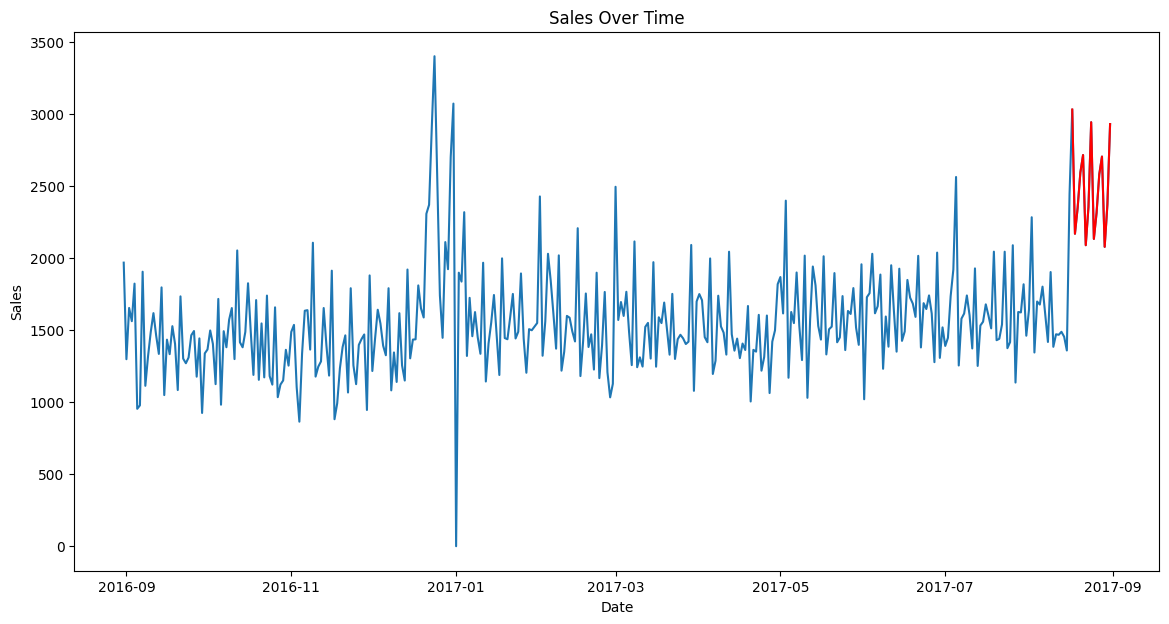

In [ ]:
def visualize_predictions_for_store_nbr_and_family(predictions, training_data, store_nbr, family):

    df = predictions.loc[(predictions["store_nbr"] == store_nbr) & (predictions["family"]==family)].copy()
    df = pd.concat([df[["date", "sales"]], training_data.loc[(training_data["store_nbr"] == store_nbr) & (training_data["family"]==family)].copy()[["date", "sales"]]])
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by="date")
    plt.figure(figsize=(14, 7))

    df = df.iloc[-365:]
    plt.plot(df['date'], df['sales'], label='Sales')

    # Highlight the last 15 data points with a different color
    plt.plot(df['date'].iloc[-15:], df['sales'].iloc[-15:], color='red', label='Last 15 Sales')

    # Adding title and labels
    plt.title('Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')

    return df

timeseries = visualize_predictions_for_store_nbr_and_family(submission, df_train, 5, "PRODUCE")